In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/named-entity-recognition-ner-corpus/ner.csv


In [2]:
! pip install tensorflow>=2.13.0,<=2.15.0
! pip install  keras==2.13.1
! pip install  keras_applications==1.0.8

/bin/bash: =2.15.0: No such file or directory
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 25.8 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 2.13.1 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 1.9 MB/s eta 0:00:00


In [3]:
! pip install tensorflow-addons
! pip install transformers
!pip install evaluate seqeval


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 13.3 MB/s eta 0:00:0000:01
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.1.5
    Uninstalling typeguard-4.1.5:
      Successfully uninstalled typeguard-4.1.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.6.4 requires numpy<1.26,>=1.16.0, but you have numpy 1.26.4 which is incompatible.
ydata-profiling 4.6.4 requires typeguard<5,>=4.1.2, but you have typeguard 2.13.3 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.7 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=93aa335d7fab2a50d0c2902642350df9fd827eac0e126825e3dfeabed248ef18
  Stored in direct

In [44]:
import spacy
import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split
import ast
import tensorflow as tf
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Input,Bidirectional,LSTM,Embedding, Masking, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D
import tensorflow_addons as tfa
from tensorflow.keras.layers import TimeDistributed
from transformers import TFBertForTokenClassification, BertTokenizer
from transformers import create_optimizer
from transformers import AutoTokenizer
from transformers import DataCollatorForTokenClassification
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer
from transformers import pipeline
from datasets import Dataset, load_dataset
import evaluate
import matplotlib.pyplot as plt
import seaborn as sns
import os 

In [5]:
# Set seaborn style
sns.set(style="whitegrid")

In [6]:
# data loader function
def loading_data(data_path):
    
    data = pd.read_csv(data_path)
    
    data.dropna(inplace=True)
    print("Number of rows : ",data.shape[0]," and the number of columns : ",data.shape[1])
    
    return data

In [7]:
#/content/ner.csv
data_path = '/kaggle/input/named-entity-recognition-ner-corpus/ner.csv'
data = loading_data(data_path)


Number of rows :  47959  and the number of columns :  4


In [8]:
# showing a sample of the data
data.sample(5).sample(5).style.set_properties(**{'background-color': '#f9f9f9', 'color': '#4CAF50', 'font-weight': 'bold'})

,Sentence #,Sentence,POS,Tag
22826,Sentence: 22827,There was no immediate claim of responsibility for either of the blasts .,"['EX', 'VBD', 'DT', 'JJ', 'NN', 'IN', 'NN', 'IN', 'DT', 'IN', 'DT', 'NNS', '.']","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']"
39703,Sentence: 39704,"The powerful quake shook the city before dawn on December 26 last year , killing thousands as they slept .","['DT', 'JJ', 'NN', 'VBD', 'DT', 'NN', 'IN', 'NN', 'IN', 'NNP', 'CD', 'JJ', 'NN', ',', 'VBG', 'NNS', 'IN', 'PRP', 'VBD', '.']","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-tim', 'I-tim', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']"
31519,Sentence: 31520,Spain and Morocco have called for a European-African summit to discuss the surge of illegal immigration from the North African country to Europe .,"['NNP', 'CC', 'NNP', 'VBP', 'VBN', 'IN', 'DT', 'JJ', 'NN', 'TO', 'VB', 'DT', 'NN', 'IN', 'JJ', 'NN', 'IN', 'DT', 'JJ', 'JJ', 'NN', 'TO', 'NNP', '.']","['B-gpe', 'O', 'B-per', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'B-gpe', 'O', 'O', 'B-geo', 'O']"
12121,Sentence: 12122,Witnesses say several civilians were killed by stray bullets and mortar fire .,"['NNS', 'VBP', 'JJ', 'NNS', 'VBD', 'VBN', 'IN', 'JJ', 'NNS', 'CC', 'NN', 'NN', '.']","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']"
4500,Sentence: 4501,Police in Denmark have arrested four Danish Muslims suspected of plotting a terror attack in Europe .,"['NNS', 'IN', 'NNP', 'VBP', 'VBN', 'CD', 'JJ', 'NNS', 'VBN', 'IN', 'VBG', 'DT', 'NN', 'NN', 'IN', 'NNP', '.']","['O', 'O', 'B-geo', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O']"


In [9]:
#data preprocessing function
def preprocess_data(data):
    for i in range(len(data)):
        pos = ast.literal_eval(data.loc[i, 'POS'])
        tags = ast.literal_eval(data.loc[i, 'Tag'])
        data.loc[i, 'POS'] = [str(word) for word in pos]
        data.loc[i, 'Tag'] = [str(word.upper()) for word in tags]
    return data

In [10]:
# preprocessing the data
data = preprocess_data(data)


In [11]:
#showing a sample of the data after the preprocessing
data.sample(5).style.set_properties(**{'background-color': '#f9f9f9', 'color': '#4CAF50', 'font-weight': 'bold'})


,Sentence #,Sentence,POS,Tag
3551,Sentence: 3552,The United States has rejected a North Korean demand to lift sanctions against Pyongyang as a condition for resuming nuclear disarmament talks .,"['DT', 'NNP', 'NNP', 'VBZ', 'VBN', 'DT', 'JJ', 'JJ', 'NN', 'TO', 'VB', 'NNS', 'IN', 'NNP', 'IN', 'DT', 'NN', 'IN', 'VBG', 'JJ', 'NN', 'NNS', '.']","['O', 'B-GEO', 'I-GEO', 'O', 'O', 'O', 'O', 'B-GPE', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']"
23186,Sentence: 23187,"Salma Hayek gave birth to a baby girl , Valentina Paloma Pinault , on September 21 .","['NNP', 'NNP', 'VBD', 'NN', 'TO', 'DT', 'NN', 'NN', ',', 'NNP', 'NNP', 'NNP', ',', 'IN', 'NNP', 'CD', '.']","['B-PER', 'I-PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PER', 'I-PER', 'I-PER', 'O', 'O', 'B-TIM', 'I-TIM', 'O']"
35874,Sentence: 35875,"Pleased and flattered to be bribed , although by nothing but an empty promise , the Judge let him go.","['JJ', 'CC', 'VBD', 'TO', 'VB', 'VBN', ',', 'IN', 'IN', 'DT', 'CC', 'DT', 'JJ', 'NN', ',', 'DT', 'NNP', 'VB', 'PRP', 'VB']","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']"
34505,Sentence: 34506,He was taken to a hospital on Saturday and is in stable condition .,"['PRP', 'VBD', 'VBN', 'TO', 'DT', 'NN', 'IN', 'NNP', 'CC', 'VBZ', 'IN', 'JJ', 'NN', '.']","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-TIM', 'O', 'O', 'O', 'O', 'O', 'O']"
39849,Sentence: 39850,"Russia strongly opposes the plan , saying the missile shield would threaten Russian security .","['NNP', 'RB', 'VBZ', 'DT', 'NN', ',', 'VBG', 'DT', 'NN', 'NN', 'MD', 'VB', 'JJ', 'NN', '.']","['B-GEO', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-GPE', 'O', 'O']"


In [12]:
#forming the final dataset
df_final = data[['Sentence','Tag']]


In [13]:
#showing a sample of the final dataset
df_final

,Sentence,Tag
0,Thousands of demonstrators have marched throug...,"[O, O, O, O, O, O, B-GEO, O, O, O, O, O, B-GEO..."
1,Families of soldiers killed in the conflict jo...,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
2,They marched from the Houses of Parliament to ...,"[O, O, O, O, O, O, O, O, O, O, O, B-GEO, I-GEO..."
3,"Police put the number of marchers at 10,000 wh...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]"
4,The protest comes on the eve of the annual con...,"[O, O, O, O, O, O, O, O, O, O, O, B-GEO, O, O,..."
...,...,...
47954,Indian border security forces are accusing the...,"[B-GPE, O, O, O, O, O, O, B-GPE, O, O, O, O, O..."
47955,Indian officials said no one was injured in Sa...,"[B-GPE, O, O, O, O, O, O, O, B-TIM, O, O, O, O..."
47956,Two more landed in fields belonging to a nearb...,"[O, O, O, O, O, O, O, O, O, O, O]"
47957,They say not all of the rockets exploded upon ...,"[O, O, O, O, O, O, O, O, O, O, O]"


In [14]:
#splitting the dataset for train and test
df_train,df_test = train_test_split(df_final,test_size=0.2,random_state=42)
len(df_train),len(df_test)

(38367, 9592)

In [15]:
#tokenizing the data
train_targets = list(df_train.Tag.values)
test_targets = list(df_test.Tag.values)

tokenizer = Tokenizer(lower=False,oov_token="UNK")
tokenizer.fit_on_texts(df_train['Sentence'])

train_inputs = tokenizer.texts_to_sequences(df_train['Sentence'])
test_inputs = tokenizer.texts_to_sequences(df_test['Sentence'])

In [16]:
word2idx = tokenizer.word_index
V = len(word2idx) # Vocab size
print("Found %s unique tokens "%V)

Found 28761 unique tokens 


In [17]:
# showing both unique train and test tags
train_tags = set([val for sublist in train_targets for val in sublist])
test_tags = set([val for sublist in test_targets for val in sublist])

print("Unique NER tags in train set: ",train_tags)
print("Unique NER tags in test set: ",test_tags)

Unique NER tags in train set:  {'I-GPE', 'I-PER', 'B-PER', 'I-ORG', 'I-TIM', 'B-ART', 'B-GPE', 'B-EVE', 'I-ART', 'B-GEO', 'I-GEO', 'O', 'I-NAT', 'B-ORG', 'I-EVE', 'B-NAT', 'B-TIM'}
Unique NER tags in test set:  {'I-GPE', 'I-PER', 'B-PER', 'I-ORG', 'I-TIM', 'B-ART', 'B-GPE', 'B-EVE', 'I-ART', 'B-GEO', 'I-GEO', 'O', 'I-NAT', 'B-ORG', 'I-EVE', 'B-NAT', 'B-TIM'}


In [18]:
tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(train_targets)
train_tgt_int = tag_tokenizer.texts_to_sequences(train_targets)
test_tgt_int = tag_tokenizer.texts_to_sequences(test_targets)

In [19]:
# Max length
max_length_train = max(len(sent) for sent in train_inputs)
max_length_test = max(len(sent) for sent in test_inputs)
max_length = max(max_length_train,max_length_test)

# Pad input sequences
train_inputs_final = pad_sequences(train_inputs,maxlen=max_length,padding="post")
print("Shape of train inputs: ",train_inputs_final.shape)

test_inputs_final = pad_sequences(test_inputs,maxlen=max_length,padding="post")
print("Shape of test inputs: ",test_inputs_final.shape)

train_targets_final = pad_sequences(train_tgt_int,maxlen=max_length,padding="post")
print("Shape of train targets: ",train_targets_final.shape)

test_targets_final = pad_sequences(test_tgt_int,maxlen=max_length,padding="post")
print("Shape of test targets: ",test_targets_final.shape)

Shape of train inputs:  (38367, 89)
Shape of test inputs:  (9592, 89)
Shape of train targets:  (38367, 89)
Shape of test targets:  (9592, 89)


In [20]:
# Number of classes
K = len(tag_tokenizer.word_index)  +1
K

18

In [21]:
# Parameters
max_length = 89
V = 10000
K = 18
vector_size = 16

In [22]:
# Unique labels
labels = [set([val for sublist in df_final['Tag'].values for val in sublist])]

# Label2index
label2index = {"O":0,"B-PER":1,"I-PER":2,"B-GEO":3,"I-GEO":4,"B-ART":5,"I-ART":6,
              "B-GPE":7,"I-GPE":8,"B-EVE":9,"I-EVE":10,"B-NAT":11,"I-NAT":12,"B-ORG":13,
              "I-ORG":14,"B-TIM":15,"I-TIM":16}

index2label = {v:k for k,v in label2index.items()}

In [23]:
# Create a column with the tokens for each sentence and numeric labels

def create_tokens(text):
    data = [word for word in text.split()]
    return data

def create_num_labels(label):
    num_label = [label2index[text] for text in label]
    return num_label

df_trf = df_final.copy()
df_trf.loc[:,'Tokens'] = df_trf['Sentence'].apply(lambda x: create_tokens(x))
df_trf.loc[:,'NER_Tags'] = df_trf['Tag'].apply(lambda label:create_num_labels(label))

# Remove rows with unequal # tokens and # tags
index_labels = []
for i in range(len(df_trf)):
    if len(df_trf['Tokens'][i]) != len(df_trf['NER_Tags'][i]):
        print(f"Tokens and tags at index {i} don't match")
        index_labels.append(i)

# Drop rows at index positions in index_labels
for idx in index_labels:
    df_trf.drop(index=idx,inplace=True)

# Reset index
df_trf.reset_index(drop=True,inplace=True)

# Select relevant columns only
df_trf = df_trf[['Tokens','NER_Tags']]
df_trf.head()

Tokens and tags at index 76 don't match
Tokens and tags at index 10051 don't match
Tokens and tags at index 19817 don't match
Tokens and tags at index 47591 don't match


,Tokens,NER_Tags
0,"[Thousands, of, demonstrators, have, marched, ...","[0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 3, 0, 0, ..."
1,"[Families, of, soldiers, killed, in, the, conf...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"[They, marched, from, the, Houses, of, Parliam...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 0]"
3,"[Police, put, the, number, of, marchers, at, 1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
4,"[The, protest, comes, on, the, eve, of, the, a...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 13,..."


In [24]:
len(df_trf)


47955

In [25]:
# Converting the dataframe to a dictionary for better conversion
df_dict = df_trf.to_dict('list')

In [27]:
raw_dataset = Dataset.from_dict(df_dict)
raw_dataset

Dataset({
    features: ['Tokens', 'NER_Tags'],
    num_rows: 47955
})

In [28]:
raw_dataset[0]


{'Tokens': ['Thousands',
  'of',
  'demonstrators',
  'have',
  'marched',
  'through',
  'London',
  'to',
  'protest',
  'the',
  'war',
  'in',
  'Iraq',
  'and',
  'demand',
  'the',
  'withdrawal',
  'of',
  'British',
  'troops',
  'from',
  'that',
  'country',
  '.'],
 'NER_Tags': [0,
  0,
  0,
  0,
  0,
  0,
  3,
  0,
  0,
  0,
  0,
  0,
  3,
  0,
  0,
  0,
  0,
  0,
  7,
  0,
  0,
  0,
  0,
  0]}

In [29]:
split = raw_dataset.train_test_split(test_size=0.15,shuffle=True,seed=42)
split

DatasetDict({
    train: Dataset({
        features: ['Tokens', 'NER_Tags'],
        num_rows: 40761
    })
    test: Dataset({
        features: ['Tokens', 'NER_Tags'],
        num_rows: 7194
    })
})

In [30]:
checkpoint = 'distilbert-base-cased'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [31]:
example = split["train"][0]
tokenized_input = tokenizer(example["Tokens"], is_split_into_words=True)
tokens = tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])
tokens

['[CLS]',
 'The',
 'NL',
 '##D',
 'was',
 'founded',
 'in',
 '1988',
 ',',
 'after',
 'the',
 'military',
 'crushed',
 'a',
 'pro',
 '-',
 'democracy',
 'uprising',
 'in',
 'Burma',
 '.',
 '[SEP]']

In [32]:
label_names = [key for key in label2index.keys()]
label_names

['O',
 'B-PER',
 'I-PER',
 'B-GEO',
 'I-GEO',
 'B-ART',
 'I-ART',
 'B-GPE',
 'I-GPE',
 'B-EVE',
 'I-EVE',
 'B-NAT',
 'I-NAT',
 'B-ORG',
 'I-ORG',
 'B-TIM',
 'I-TIM']

In [33]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["Tokens"], truncation=True, is_split_into_words=True)

    labels = []
    for i, label in enumerate(examples[f"NER_Tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # Map tokens to their respective word.
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:  # Set the special tokens to -100.
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:  # Only label the first token of a given word.
                label_ids.append(label[word_idx])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [34]:
# Apply the preprocessing function over dataset

tokenized_dataset = split.map(tokenize_and_align_labels,batched=True)
tokenized_dataset

Map:   0%|          | 0/40761 [00:00<?, ? examples/s]

Map:   0%|          | 0/7194 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['Tokens', 'NER_Tags', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 40761
    })
    test: Dataset({
        features: ['Tokens', 'NER_Tags', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 7194
    })
})

In [35]:
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)


In [40]:
seqeval = evaluate.load("seqeval")

In [36]:
labels = [label_names[i] for i in example[f"NER_Tags"]]


def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = [
        [label_names[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_names[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = seqeval.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

In [37]:
model = AutoModelForTokenClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=17, id2label=index2label, label2id=label2index
)

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [41]:
training_args = TrainingArguments(
    output_dir="ner_model",
    learning_rate=2e-5,
    per_device_train_batch_size=9,
    per_device_eval_batch_size=6,
    num_train_epochs=4,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)



/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [42]:
trainer.train()

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.145900,0.132016,0.768333,0.768885,0.768609,0.960846
2,0.111900,0.114006,0.777495,0.805907,0.791446,0.965103
3,0.092200,0.111155,0.791407,0.814353,0.802716,0.966808
4,0.079300,0.110403,0.795370,0.814952,0.805042,0.967438


/opt/conda/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but 

TrainOutput(global_step=9060, training_loss=0.11190517569746139, metrics={'train_runtime': 1135.1045, 'train_samples_per_second': 143.638, 'train_steps_per_second': 7.982, 'total_flos': 1936591983261414.0, 'train_loss': 0.11190517569746139, 'epoch': 4.0})

In [46]:
ner = pipeline("token-classification",
               model = '/kaggle/working/ner_model/checkpoint-9060',
               device = 0)

In [47]:
text = "On 24 February 2022, Russia invaded Ukraine in an escalation of the Russo-Ukrainian War which began in 2014."
ner(text)

[{'entity': 'B-TIM',
  'score': 0.96192807,
  'index': 2,
  'word': '24',
  'start': 3,
  'end': 5},
 {'entity': 'B-TIM',
  'score': 0.9703784,
  'index': 3,
  'word': 'February',
  'start': 6,
  'end': 14},
 {'entity': 'I-TIM',
  'score': 0.9921176,
  'index': 4,
  'word': '202',
  'start': 15,
  'end': 18},
 {'entity': 'I-TIM',
  'score': 0.9947977,
  'index': 5,
  'word': '##2',
  'start': 18,
  'end': 19},
 {'entity': 'B-GEO',
  'score': 0.86204904,
  'index': 7,
  'word': 'Russia',
  'start': 21,
  'end': 27},
 {'entity': 'B-GEO',
  'score': 0.9084674,
  'index': 9,
  'word': 'Ukraine',
  'start': 36,
  'end': 43},
 {'entity': 'B-TIM',
  'score': 0.9935487,
  'index': 24,
  'word': '2014',
  'start': 103,
  'end': 107}]

In [48]:
text = "Google was founded on September 4, 1998, by American computer scientists Larry Page and Sergey Brin while they were PhD students at Stanford University in California."
ner(text)

[{'entity': 'B-ORG',
  'score': 0.6526238,
  'index': 1,
  'word': 'Google',
  'start': 0,
  'end': 6},
 {'entity': 'B-TIM',
  'score': 0.9981475,
  'index': 5,
  'word': 'September',
  'start': 22,
  'end': 31},
 {'entity': 'I-TIM',
  'score': 0.997823,
  'index': 6,
  'word': '4',
  'start': 32,
  'end': 33},
 {'entity': 'I-TIM',
  'score': 0.9908199,
  'index': 7,
  'word': ',',
  'start': 33,
  'end': 34},
 {'entity': 'I-TIM',
  'score': 0.8984177,
  'index': 8,
  'word': '1998',
  'start': 35,
  'end': 39},
 {'entity': 'B-GPE',
  'score': 0.95925784,
  'index': 11,
  'word': 'American',
  'start': 44,
  'end': 52},
 {'entity': 'B-PER',
  'score': 0.7562226,
  'index': 14,
  'word': 'Larry',
  'start': 73,
  'end': 78},
 {'entity': 'I-PER',
  'score': 0.87719053,
  'index': 15,
  'word': 'Page',
  'start': 79,
  'end': 83},
 {'entity': 'B-PER',
  'score': 0.77846414,
  'index': 17,
  'word': 'Sergey',
  'start': 88,
  'end': 94},
 {'entity': 'I-PER',
  'score': 0.9702322,
  'index'

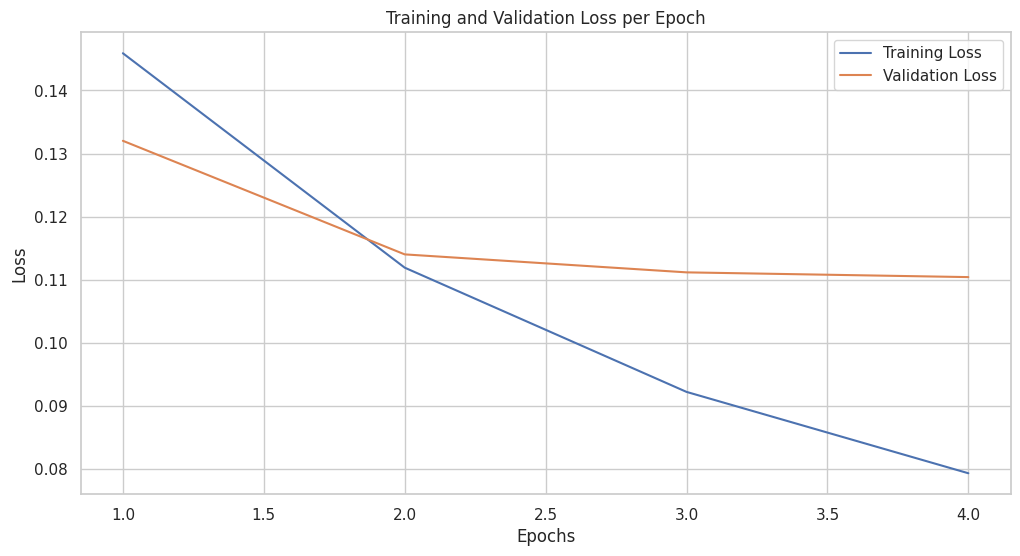

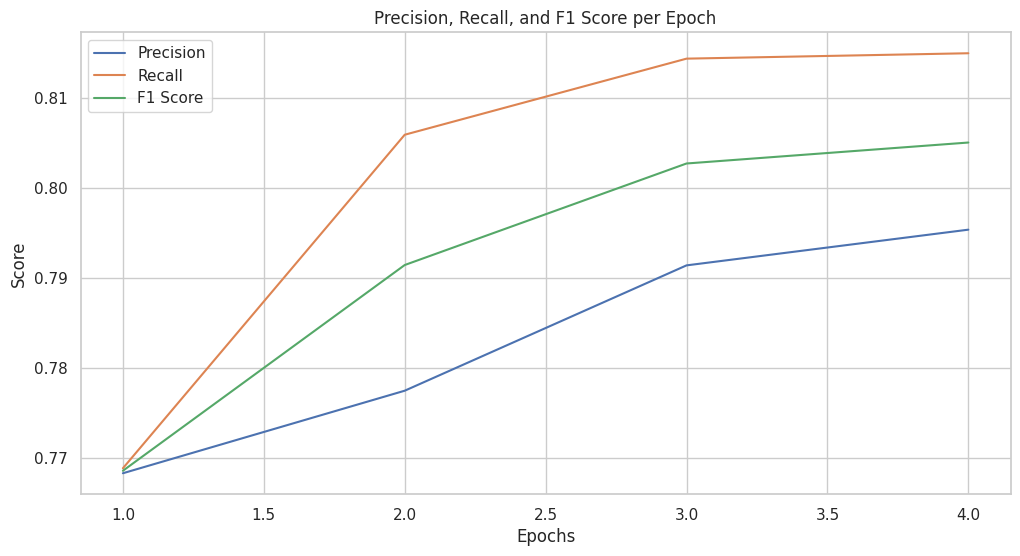

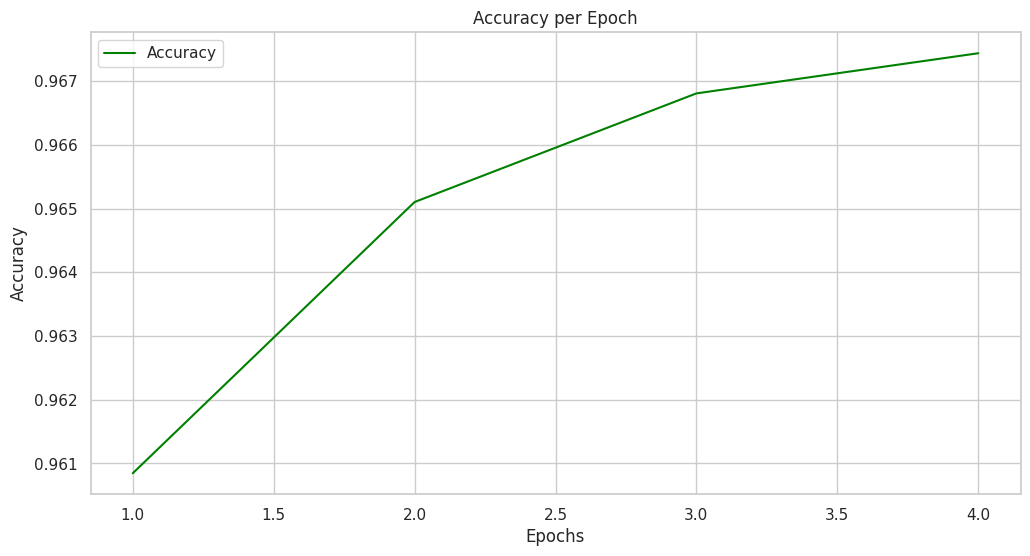

In [49]:
import matplotlib.pyplot as plt

# Data
epochs = [1, 2, 3, 4]
training_loss = [0.145900, 0.111900, 0.092200, 0.079300]
validation_loss = [0.132016, 0.114006, 0.111155, 0.110403]
precision = [0.768333, 0.777495, 0.791407, 0.795370]
recall = [0.768885, 0.805907, 0.814353, 0.814952]
f1_score = [0.768609, 0.791446, 0.802716, 0.805042]
accuracy = [0.960846, 0.965103, 0.966808, 0.967438]

# Plot Training and Validation Loss
plt.figure(figsize=(12, 6))
plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, validation_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()

# Plot Precision, Recall, and F1 Score
plt.figure(figsize=(12, 6))
plt.plot(epochs, precision, label='Precision')
plt.plot(epochs, recall, label='Recall')
plt.plot(epochs, f1_score, label='F1 Score')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 Score per Epoch')
plt.legend()
plt.grid(True)
plt.show()

# Plot Accuracy
plt.figure(figsize=(12, 6))
plt.plot(epochs, accuracy, label='Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch')
plt.legend()
plt.grid(True)
plt.show()
